# Major Analysis For Consulting Group

This is the analysis for the organization that is going to take over the enrollment and recruitment for [select majors].

## Fill Rates of Classes

In [1]:
import pandas as pd
import numpy as np

from pathlib import Path
import os

from utilities import retrieve_and_open_csv_files

import warnings
warnings.filterwarnings('ignore')

DATA_PATH = Path.cwd()/'Data'

In [2]:
# Load DAR data
fill = (retrieve_and_open_csv_files(DATA_PATH, keyword = '201980')
            .rename(columns = str.lower)
       )

### Data Exploration

The *fill* dataset contains 339 rows and 29 columns. Each row is a class that was taught in the [select majors] department between 201980 and 202310. 

To account for academy duplicate courses, I created an alternate CRN for the courses in which if a course was a CONA course, I changed its CRN to match the CRN of the traditional course. This way, when I aggregated and summed the number of students enrolled, I get only one total for that CRN. Just by combining the CONA courses with the tradiational courses, that reduced the number of courses from 339 to 283. Then I noticed that there were many courses that had 0 enrolled and 0 maximum seats allowed; so I removed those. That eliminated 64 more classes over all these semesters and left 213 individual classes taught in this program from Fall 2019 to Spring 2023.

Out of the eight semesters we are considering in this analysis, only seven classes that were academy classes show up as having a fill rate above 100%. To deal with that, I reduced all of them to 100% fill rate since we have no way to automate how many students *could have fit* into the classrooms in which these courses met.

**Outcomes of Analysis**

One of the outcomes of this analysis that was unintentional was the discovery that the director of the program had arbitrarily changed the number of seats available for each of his classes. The Academic VP has an initiative of reducing cost by having higher fill rates for each class, which is simply the number of seats taken in a class divided by the number of seats available. Consequently, if one were to reduce the number of seats available in the denominator, it would make the fill rates look better even when they are not. 

The other consequent of this is that it would make the new director's numbers look as good or better than the previous director.  The previous director of the program had great fill rates but more seats available. In order to make a true comparison between the two directors, past and present, I made sure to change the present classes' available seats, to match what they were before the new director took over. 

In [3]:
# create dataframe that sums the number of students in each class
# and the maximum number allowed
fill_rate = (fill.groupby(['term', 'alt_crn', 'sub', 'crs'])
                .agg({'enrl':'sum',
                      'maxenr':'sum'})
                .reset_index()
            )

# filter out all courses in which there are 0 students enrolled
# and 0 max seats allowed.
mask1 = fill_rate['enrl'] != 0
mask2 = fill_rate['maxenr'] != 0

fill_rate = fill_rate[mask1 & mask2]

# I implemented an algorithm that searched through the courses using the 
# skills list below as the filter. If a class is a skills class and it 
# was less than 15, then it was changed to 15. If a class was not in the 
# skills list and had fewer than 24 max seats, it was changed to 24. 
# Otherwise, it was all kept the same.
skills_classes = retrieve_and_open_csv_files(DATA_PATH, keyword='Skills')
skills = list(skills_classes['sub_crs'])

# Create a combined sub_crs column
fill_rate['sub_crs'] = [i + " " + str(j) for i, j in zip(fill_rate['sub'], fill_rate['crs'])]

# Implement the algorithm
enrmax = []

for i in range(len(fill_rate['sub_crs'])):
    if fill_rate['sub_crs'].iloc[i,] not in skills:
        enrmax.append(24)
    elif fill_rate['sub_crs'].iloc[i,] in skills and fill_rate['maxenr'].iloc[i,] < 15 and fill_rate['term'].iloc[i,] < 202210:
        enrmax.append(15)
    elif fill_rate['sub_crs'].iloc[i,] in skills and fill_rate['maxenr'].iloc[i,] < 12 and fill_rate['term'].iloc[i,] >= 202210:
        enrmax.append(12)
    else:
        enrmax.append(fill_rate['maxenr'].iloc[i,])

# Add the new max seats column
fill_rate['new_max'] = enrmax

# create a new column that shows the percentage of seats filled 
# for each class each semester
fill_rate['fill_rate'] = round(fill_rate['enrl'] / fill_rate['new_max'] * 100, 2)

In [4]:
# Identify average fill rate per semester
fill_rate.groupby('term').agg({'fill_rate':'mean'}).reset_index()

,term,fill_rate
0,201980,49.139032
1,202010,47.450800
2,202080,39.111000
3,202110,37.275000
4,202180,36.217308
5,202210,30.564333
6,202280,47.644348
7,202310,44.270833


In [5]:
# Show fill rates for the individual classes for all terms
all_terms = []

for term in fill_rate['term'].unique():
    temp_tbl = (fill_rate[fill_rate['term'] == term].sort_values(['sub', 'crs'])
                   [['term', 'alt_crn', 'sub_crs', 'enrl', 'new_max', 'fill_rate']]
                   .reset_index(drop = True)
               )
    all_terms.append(temp_tbl)

all_term_fill_rate = pd.concat(all_terms).reset_index(drop = True)

all_term_fill_rate.head(10)

,term,alt_crn,sub_crs,enrl,new_max,fill_rate
0,201980,15670,CA 109,21,24,87.50
1,201980,16707,CA 109,14,24,58.33
2,201980,18788,CA 109,7,24,29.17
3,201980,15603,CA 120,9,15,60.00
4,201980,15604,CA 120,12,15,80.00
5,201980,15606,CA 120,7,15,46.67
6,201980,15607,CA 120,9,15,60.00
7,201980,18789,CA 120,5,15,33.33
8,201980,15610,CA 130,8,24,33.33
9,201980,15611,CA 130,7,24,29.17


## Credit Hour Enrollment Analysis

In [6]:
# Load crhr data
crhr = (retrieve_and_open_csv_files(DATA_PATH, keyword = 'CrHr Enrollment')
            .rename(columns = str.lower)
       )

In [7]:
# create unique object for total credits taken per student per 
# semester
semcrhr = (crhr.groupby(['id', 'term', 'totcr'])
               .first()
               .reset_index()
          )

### Bar Charts Of CrHr Enrollment By Semester

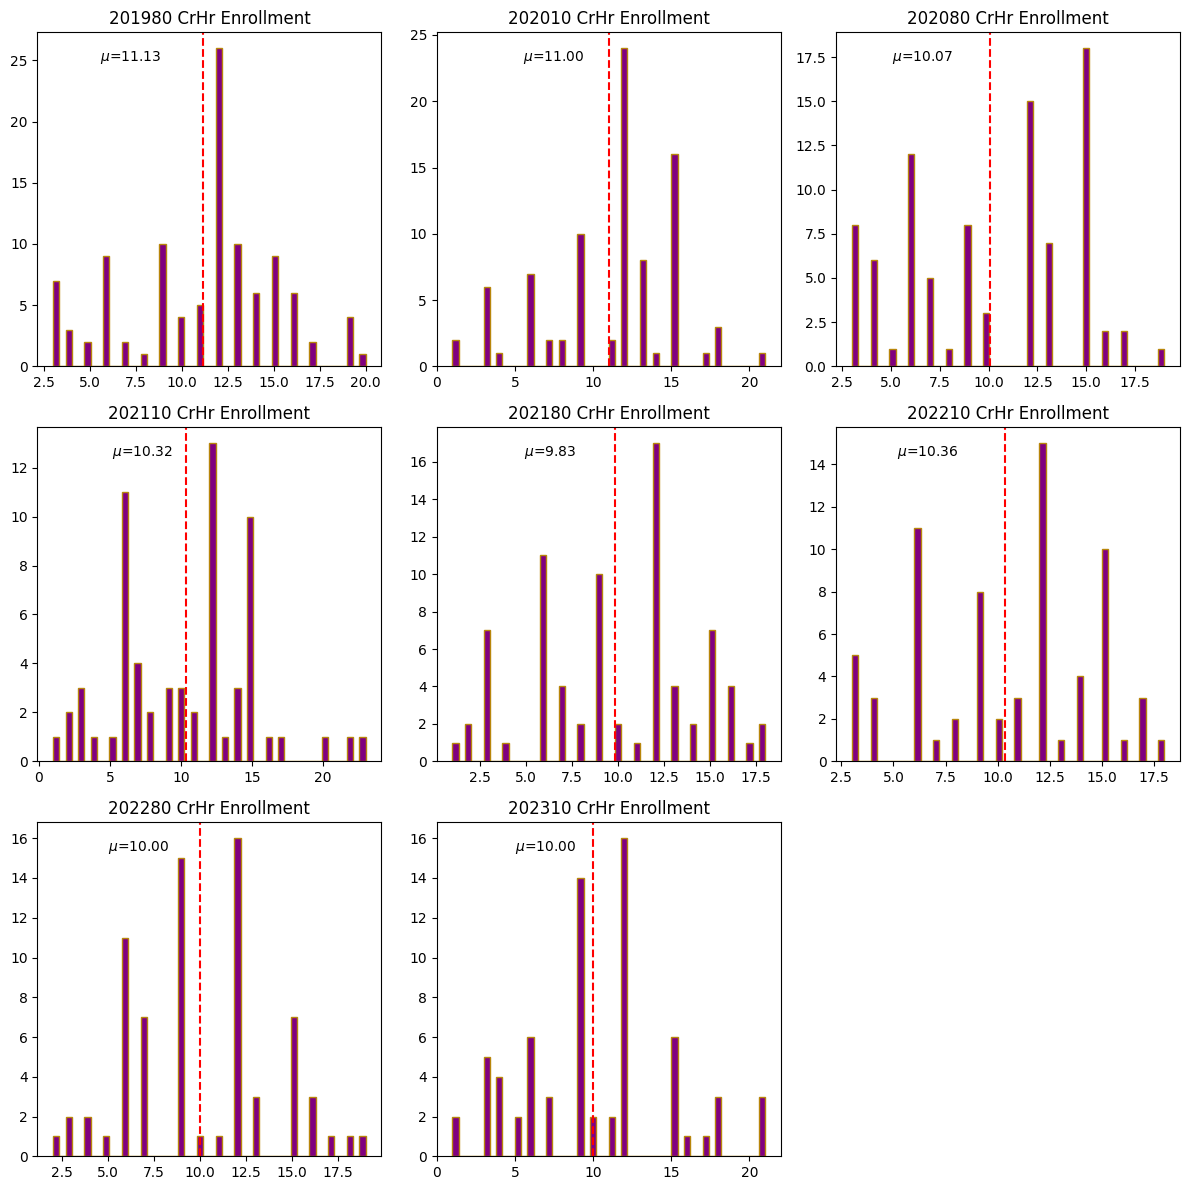

In [8]:
import matplotlib.pyplot as plt

# Set the colors
hist_color = 'purple'
hist_edge_color = 'darkgoldenrod'

# Create a 3 x 3 matrix of histograms for each cluster label
fig, axes = plt.subplots(nrows = 3, ncols = 3, figsize = (12, 12))

# Flatten the axes array for indexing
axes = axes.flatten()

term = [201980, 202010,202080, 202110, 202180, 202210, 202280, 202310]

# Loop through each semester and create histogram
for i in range(8):
    ax = axes[i] 
    cr_data = semcrhr[semcrhr['term'] == term[i]]['totcr']
    ax.hist(cr_data, bins = 50, color = hist_color, edgecolor = hist_edge_color)
    ax.set_title(f'{term[i]} CrHr Enrollment')
    ax.axvline(x = cr_data.mean(), color = 'red', linestyle = 'dashed')
    ax.text(cr_data.mean() * .50, ax.get_ylim()[1] * 0.95, r'$\mu$=' + f'{cr_data.mean():.2f}', va = 'top')

# Hide any unused subplots
for j in range(8, 9):
    axes[j].set_visible(False)

# Add spacing between subplots
fig.tight_layout()

# Show plots
plt.show()

### Density Plots of Age of Students In Programs Along With Mean

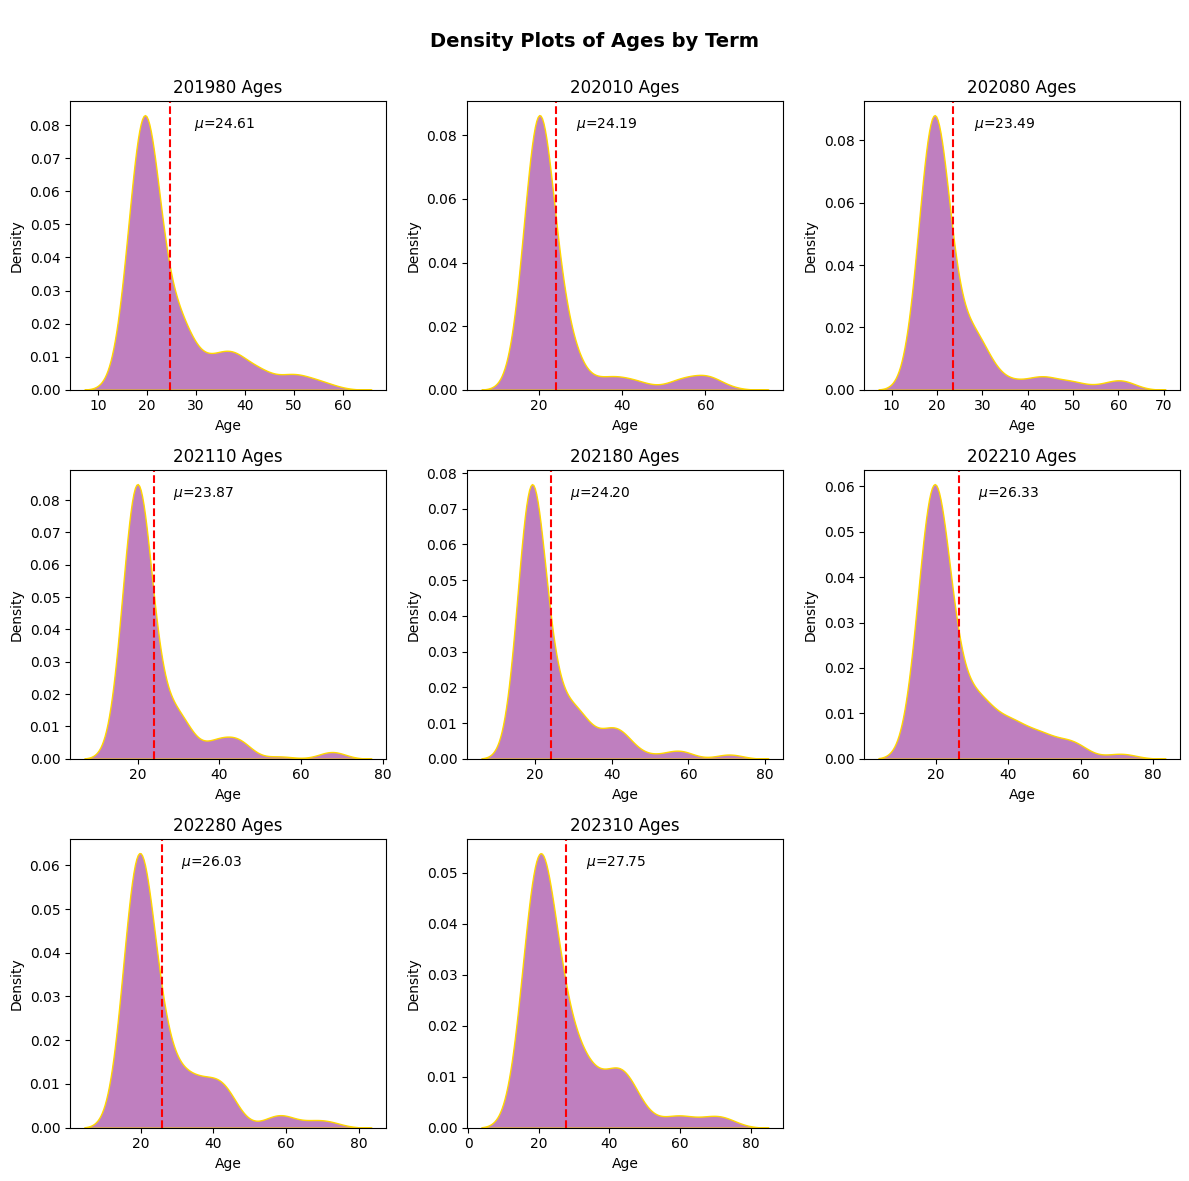

In [9]:
# Create age distribution
import seaborn as sns
import matplotlib.pyplot as plt

terms = [201980, 202010,202080, 202110, 202180, 202210, 202280, 202310]

# create a subplot figure with 3 rows and 3 columns
fig, axes = plt.subplots(nrows = 3, ncols = 3, figsize = (12, 12))

# iterate over the clusters to plot
for i, term in enumerate(terms):
    
    # get the age data for the current term
    data = crhr.loc[crhr['term'] == term, 'age']
    
    # get the subplot axes for the current term
    ax = axes[i // 3, i % 3]
    
    # plot the density plot for the current term
    sns.kdeplot(data, ax = ax, fill = True, color = 'purple', alpha = 0.5, edgecolor = 'gold')
    
    # set the subplot title to the current term label
    ax.set_title('{} Ages'.format(term))
    ax.axvline(x = data.mean(), color = 'red', linestyle = 'dashed')
    ax.text(data.mean() * 1.2, ax.get_ylim()[1] * 0.95, r'$\mu$=' + f'{data.mean():.2f}', va = 'top') 

    # set the x and y axis labels
    ax.set_xlabel('Age')
    ax.set_ylabel('Density')

# hide the empty subplots
for i in range(len(terms), 9):
    axes[i // 3, i % 3].set_visible(False)

# adjust the subplot layout and display plots
fig.suptitle("\nDensity Plots of Ages by Term\n", fontsize = 14, fontweight = 'bold')
plt.tight_layout()
plt.show()

### Contour plot of Age And CrHrs Taken

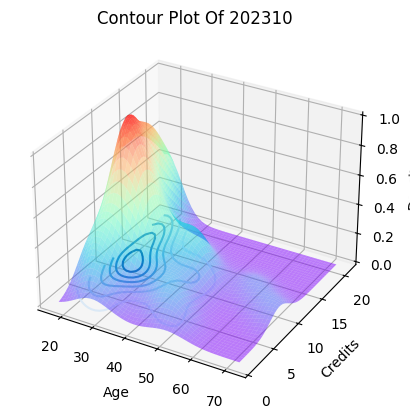

In [10]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.stats import gaussian_kde

# Create a 3D figure
fig = plt.figure()
ax = fig.add_subplot(111, projection = '3d')

# Evaluate the KDE
kde_clust = crhr[crhr['term'] == terms[7]]
x = kde_clust['age']
y = kde_clust['totcr']
kde = gaussian_kde([x, y])

# Create a grid of points
xmin, xmax = x.min(), x.max()
ymin, ymax = y.min(), y.max()
x_grid, y_grid = np.meshgrid(np.linspace(xmin, xmax, 50), np.linspace(ymin, ymax, 50))
z_grid = kde(np.vstack([x_grid.ravel(), y_grid.ravel()]))

# Reshape the grid and normalize the density values
z_grid = z_grid.reshape(x_grid.shape)
z_grid = z_grid / z_grid.max()

# Plot the 3D surface
ax.plot_surface(x_grid, y_grid, z_grid, cmap = "rainbow", alpha = 0.5)
ax.contour(x_grid, y_grid, z_grid, zdir = 'z', offset = z_grid.min(), cmap = "Blues")
ax.set_xlabel('Age')
ax.set_ylabel('Credits')
ax.set_zlabel('Density')

# Show the plot
plt.title('Contour Plot Of 202310')
plt.show()

### Apriori Algorithm of Classes

*A Priori* algorithm is an association rule mining algorithm used most often in the retial/purchasing space for discovering products or services that are often bought together more frquently than a predefined threshold. Here, I wanted to see if it might reveal unique pairings of courses that students "purchase" (i.e. take) more frequently than would otherwise be expected. In doing so, it would help with scheduling so that those courses could be offered in a complimentary way. 

**Outcome**

While this analysis did not reveal new groupings of classes we were unaware of, it enabled us to go to the director with statistical backing to suggests which courses needed to be deliberately programmed together, for instnace, one on Tuesdays from 8:30 - 11:30 and the complimentary course on Tuesdays from 12:30-3:30. 

In [ ]:
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori, association_rules

crhr['sub_crs'] = [(i + " " + str(j)) for i, j in zip(crhr['sub'], crhr['crs'])]
crhr['termid'] = [(str(i) + j) for i, j in zip(crhr['term'], crhr['id'])]

# Set 'termid' as the index
crhr.set_index('termid', inplace = True)

# Group the 'sub_crs' column by 'termid' and create a list of itemsets
itemsets = crhr.groupby('termid')['sub_crs'].apply(list).tolist()

# Convert the list of itemsets to a one-hot encoded dataframe
te = TransactionEncoder()
te_ary = te.fit_transform(itemsets)
df = pd.DataFrame(te_ary, columns = te.columns_)

# Apply the Apriori algorithm to the one-hot encoded dataframe
frequent_itemsets = apriori(df, min_support = 0.2, use_colnames = True)

# Print the frequent itemsets
frequent_itemsets

In [ ]:
#  We set our metric as "Lift" to define whether antecedents & consequents are dependent our not
rules = association_rules(frequent_itemsets, metric = "lift", min_threshold = 0.0001)

rules["antecedents_length"] = rules["antecedents"].apply(lambda x: len(x))

rules["consequents_length"] = rules["consequents"].apply(lambda x: len(x))

(rules.sort_values("lift",ascending=False).reset_index(drop = True)
     [['antecedents', 'consequents', 'confidence', 'lift', 'leverage', 'conviction', 
       'antecedents_length', 'consequents_length']]
)

In [ ]:
crhr['day_time'] = [(i + " " + j) for i, j in zip(crhr['days'], crhr['start_time'])]

# Group the 'sub_crs' column by 'termid' and create a list of itemsets
itemsets = crhr.groupby('termid')['start_time'].apply(list).tolist()

# Convert the list of itemsets to a one-hot encoded dataframe
te = TransactionEncoder()
te_ary = te.fit_transform(itemsets)
df = pd.DataFrame(te_ary, columns = te.columns_)

# Apply the Apriori algorithm to the one-hot encoded dataframe
frequent_itemsets = apriori(df, min_support = 0.2, use_colnames = True)

# Print the frequent itemsets
frequent_itemsets

In [ ]:
#  We set our metric as "Lift" to define whether antecedents & consequents are dependent our not
rules = association_rules(frequent_itemsets, metric = "lift", min_threshold = 1.2)

rules["antecedents_length"] = rules["antecedents"].apply(lambda x: len(x))

rules["consequents_length"] = rules["consequents"].apply(lambda x: len(x))

(rules.sort_values("lift",ascending = False).reset_index(drop = True)
     [['antecedents', 'consequents', 'confidence', 'lift', 'leverage', 'conviction', 
       'antecedents_length', 'consequents_length']]
)